Step 3 notebooks are revolved around using the latent space.

Steps performed in this notebook:

**1. Load in CCA dataframes:** Created by notebook 2-perform_cca.

**2. Nearest neighbour search:** For every query X, the latent space is searched for *n* amount of nearest target Y points using cosine or euclidean distance. These *n* amount of matches are then compared to the 'real' Y that corresponds to the query X by calculating the **tanimoto similarity** between the two respective structures. Out of all the tanimoto scores, the max one is taken and then used to make a distribution plot. And this is done for different amounts of nearest neighbours. Additionally, a random distribution is also plotted to show if the real distribution is better or worse than random.

In [1]:
# Set plot style
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

import matplotlib.style as style
style.use('ggplot')
%matplotlib inline

## 1. Load in CCA dataframes

In [2]:
import os
import pickle

# Load the CCA latent spaces for Spec2Vec and MS2DeepScore

def load_pickle(fn, path):
    with open(os.path.join(path, '%s.pickle' % fn), 'rb') as f:
        df = pickle.load(f) 
    return df

latent_dims = 100

df_spec2vec_cca = load_pickle('dataframe_spec2vec_cca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_dcca = load_pickle('dataframe_spec2vec_dcca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')

df_ms2ds_cca = load_pickle('dataframe_ms2ds_cca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')
df_ms2ds_dcca = load_pickle('dataframe_ms2ds_dcca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')

In [3]:
dataset = "ALL_GNPS_210409_positive"

path = os.path.join("/mnt/LTR_userdata/hooft001/mass_spectral_embeddings", "datasets", dataset)

# Load in tanimoto similarity matrix for comparisons later
tanimoto_fn = os.path.join(path, "%s_tanimoto_scores.pickle" % dataset)
with open(tanimoto_fn, "rb") as f:
    tanimoto_matrix = pickle.load(f)

## 2. Nearest Neighbour Search
Here, the latent space is utilized to do cross-modal retrieval using cosine distance as a distance measure. Also, in order to do some benchmarking, nearest neighbour search is also performed in the spectral embeddings alone. Hits are judged on Tanimoto similarity. In the ideal world, you would query a spectra, and then retrieve the structure that belongs to that spectra.

The number of neighbours is specified as a list. The distance metric can be either cosine or euclidean, or another one that is supported by `scipy.spatial.distance`.

First, for every spectral query the max number of structural nearest neighbours (nns) are found. E.g., if the highest number of nns in the `nn_list` is 100, then it will find 100 matches. The list can then later be shortened for the lower number of nns, instead of having to refind all the matches.

In [4]:
import heapq
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.spatial import distance

def get_tanimoto_df(all_tanimoto_list, nn_list, method):
    """From list of e.g. 100 nn results, cut off list at certain points for plotting
    and then take the max tanimoto of those nearest neighbours.
    """
    tanimoto_dict = {}
    for nn in nn_list:  # Loop through nns
        tanimoto_list = []
        for all_tanimoto in all_tanimoto_list:  # Loop through matches
            curr_tanimoto = all_tanimoto[:nn]  # Cut off at certain spots
            if method == 'max':
                tanimoto = max(curr_tanimoto)  # Get max over all nearest neighbours
            else:
                tanimoto = np.mean(curr_tanimoto) # Get avg over all nearest neighbours
            tanimoto_list.append(tanimoto)
        tanimoto_dict[nn] = tanimoto_list
    return pd.DataFrame(tanimoto_dict)

def perform_tanimoto_steps(df_query, df_library, nn_list, metric, x, y, method, self_allowed, random, set_type='train'):
    """Perform all steps to get matches based on lowest distance, get tanimoto similarity for each match, 
    and get max tanimoto similarity for each group of nearest neighbours.
    -------------------------
    nn_list: list of n nearest neighbours in inverse order
    metric: cosine, euclidean
    """
    
    max_nn = max(nn_list)
    
    # Make distance matrix between X and Y
    cdist_matrix = distance.cdist([x for x in df_query[x]],
                                  [x for x in df_library[y]],
                                  metric=metric)

    # loop hrough each row in the dist matrix
    all_tanimoto_list = []
    for i, dist_list in enumerate(tqdm(cdist_matrix)): 
        # Get query info
        query = df_query.iloc[[i]]  # iloc looks by row number; 0, 1, 2...
        q_inchi = query.inchikey14.values[0]  # Get first 14 chars of inchikey of query
        
        # Turn distances into dataframe
        dist_df = pd.DataFrame(dist_list, columns=['dist'], index=df_library.inchikey14)

        # Add option to exclude self-matches, e.g. when query and library are same embedding
        if not self_allowed:
            dist_df.drop(q_inchi, inplace=True)  # Remove self-match 
            
        # Sort on distance from small to high
        dist_df.sort_values(by='dist', inplace=True)

        # Take top n nearest neighbours, and keep only the inchikeys
        if random:
            inchis = df_library.sample(max_nn).inchikey14.values  # Get n random inchikey14 values
        else:
            inchis = dist_df[:max_nn].index.values

        # Get tanimoto similarities of (random) matches with query
        tanimoto_list = tanimoto_matrix[q_inchi][inchis].values
        
        all_tanimoto_list.append(tanimoto_list)
        
    tanimoto_df = get_tanimoto_df(all_tanimoto_list, nn_list, method)
    
    # Add column to indicate if train or test data
    #tanimoto_df['set'] = set_type
        
    return tanimoto_df

def get_tanimoto_train(df, nn_list, metric='cosine', x='X', y='Y', method='max', self_allowed=True, random=False):
    """All the functions above are performed for train
    """
    df_train = df[df['set'] == 'train']
    tanimoto_df = perform_tanimoto_steps(df_train, df_train, nn_list, metric, x, y, method, self_allowed, random)
    return tanimoto_df

def get_tanimoto_test(df, nn_list, metric='cosine', x='X', y='Y', method='max', self_allowed=True, random=False):
    """# Look with test dataset in train in order to have a more even comparison between Spec2Vec and CCA
    """
    df_train = df[df['set'] == 'train']
    df_test = df[df['set'] == 'test']
    tanimoto_df = perform_tanimoto_steps(df_test, df_train, nn_list, metric, x, y, method, self_allowed, random)
    return tanimoto_df

import seaborn as sns

In [5]:
# Prediction settings
nn_list = [1, 10, 100]
metric = 'cosine'

### 2.1. Test in train (no self-matches)
Self-matches need to be excluded in order to compare the cross-modal retrieval with the joint embedding to the nearest neighbour search in the spectral embedding alone. Therefore, test spectra are queried in the train space. Results show that MS2DeepScore by itself performs best here, followed by Spec2Vec by itself, followed by Spec2Vec+CCA. DCCA performs the worst.

In [6]:
# Make distribution plots
def make_distribution_plot(tanimoto_df, title, p):
    tanimoto_df_m = tanimoto_df.melt(id_vars=['embedding'], var_name='nn', value_name='tanimoto')
    g = sns.FacetGrid(tanimoto_df_m, col='nn', hue='embedding', height=2.5, aspect=1.5, palette=p)
    g.map(sns.kdeplot, 'tanimoto')
    g.add_legend()
    #g.fig.suptitle('Tanimoto similarity distribution %s' % title, y=1.1, size='large', weight='semibold')
    
p = ["darkgray", "orchid", "lightseagreen", "mediumpurple", "chocolate"]

In [7]:
# Spec2Vec
tanimoto_pre_cca = get_tanimoto_test(df_spec2vec_cca, nn_list, metric, x='spec2vec', y='spec2vec')
tanimoto_post_cca = get_tanimoto_test(df_spec2vec_cca, nn_list, metric, x='X', y='Y')
tanimoto_post_dcca = get_tanimoto_test(df_spec2vec_dcca, nn_list, metric, x='X', y='Y')
tanimoto_random = get_tanimoto_test(df_spec2vec_cca, nn_list, metric, x='X', y='Y', random=True)

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

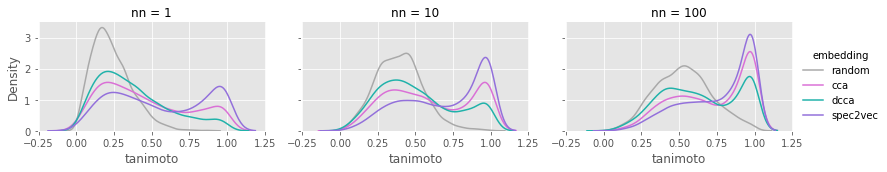

In [8]:
# Combine into one dataframe for plotting
tanimoto_comparison_df = pd.concat([tanimoto_random, tanimoto_post_cca, tanimoto_post_dcca, tanimoto_pre_cca], 
                                      keys=['random', 'cca', 'dcca', 'spec2vec'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(tanimoto_comparison_df, "", p)

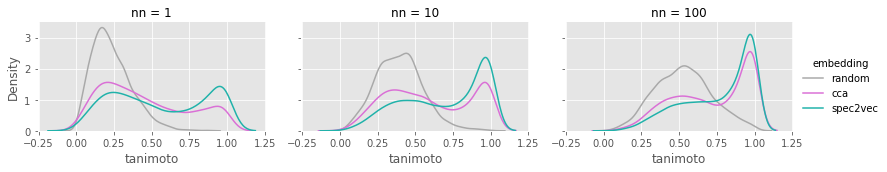

In [9]:
# Without DCCA for thesis
tanimoto_comparison_df = pd.concat([tanimoto_random, tanimoto_post_cca, tanimoto_pre_cca], 
                                      keys=['random', 'cca', 'spec2vec'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(tanimoto_comparison_df, "", p)

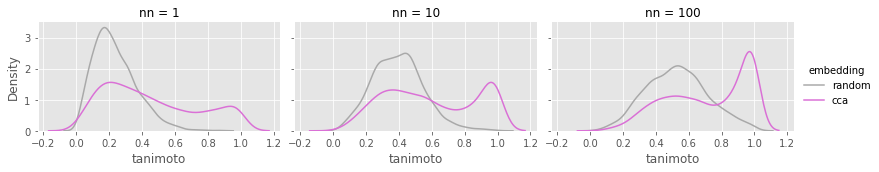

In [10]:
# Without spec2vec for presentation
tanimoto_comparison_df = pd.concat([tanimoto_random, tanimoto_post_cca], 
                                      keys=['random', 'cca'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(tanimoto_comparison_df, "", p)

In [11]:
# MS2DeepScore
tanimoto_pre_cca_ms2ds = get_tanimoto_test(df_ms2ds_cca, nn_list, metric, x='ms2ds', y='ms2ds')
tanimoto_post_cca_ms2ds = get_tanimoto_test(df_ms2ds_cca, nn_list, metric, x='X', y='Y')
tanimoto_post_dcca_ms2ds = get_tanimoto_test(df_ms2ds_dcca, nn_list, metric, x='X', y='Y')
tanimoto_random_ms2ds = get_tanimoto_test(df_ms2ds_cca, nn_list, metric, x='X', y='Y', random=True)

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

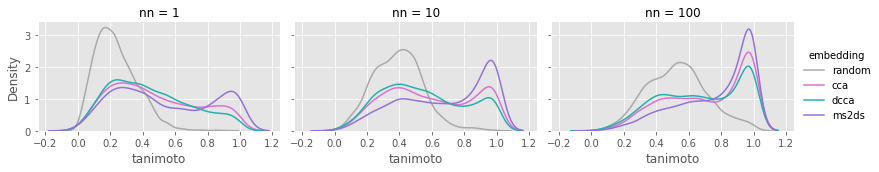

In [12]:
# Combine into one dataframe for plotting
tanimoto_comparison_df_ms2ds = pd.concat([tanimoto_random_ms2ds, tanimoto_post_cca_ms2ds, 
                                          tanimoto_post_dcca_ms2ds, tanimoto_pre_cca_ms2ds], 
                                      keys=[ 'random', 'cca', 'dcca', 'ms2ds'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(tanimoto_comparison_df_ms2ds, "", p)

### 2.2 Train in train (self-matches)
Results here show that Spec2Vec performs better than MS2DeepScore when combined into the joint embedding with Mol2Vec.

In [13]:
# Spec2Vec
tanimoto_cca_train = get_tanimoto_train(df_spec2vec_cca, nn_list, metric, x='X', y='Y')
tanimoto_dcca_train = get_tanimoto_train(df_spec2vec_dcca, nn_list, metric, x='X', y='Y')
tanimoto_random_train = get_tanimoto_train(df_spec2vec_cca, nn_list, metric, x='X', y='Y', random=True)

  0%|          | 0/12116 [00:00<?, ?it/s]

  0%|          | 0/10904 [00:00<?, ?it/s]

  0%|          | 0/12116 [00:00<?, ?it/s]

In [14]:
# MS2DeepScore
tanimoto_cca_train_ms2ds = get_tanimoto_train(df_ms2ds_cca, nn_list, metric, x='X', y='Y')
tanimoto_dcca_train_ms2ds = get_tanimoto_train(df_ms2ds_dcca, nn_list, metric, x='X', y='Y')
tanimoto_random_train_ms2ds = get_tanimoto_train(df_ms2ds_cca, nn_list, metric, x='X', y='Y', random=True)

  0%|          | 0/12116 [00:00<?, ?it/s]

  0%|          | 0/10904 [00:00<?, ?it/s]

  0%|          | 0/12116 [00:00<?, ?it/s]

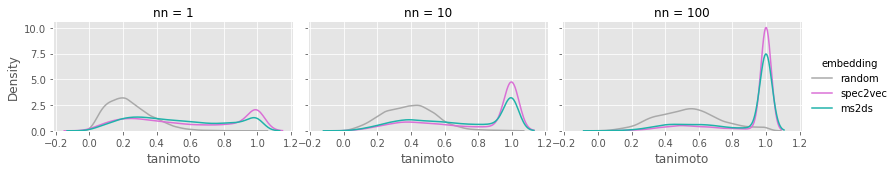

In [15]:
# With self-matches 
comb_tanimoto_df_self = pd.concat([tanimoto_random_train, tanimoto_cca_train, tanimoto_cca_train_ms2ds],
                                  keys=['random', 'spec2vec', 'ms2ds'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(comb_tanimoto_df_self, "", p)

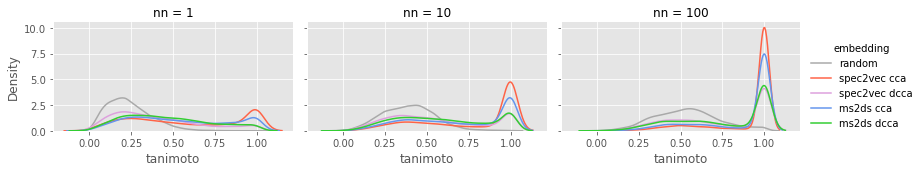

In [16]:
# All with self-matches 
comb_tanimoto_df_self = pd.concat([tanimoto_random_train, tanimoto_cca_train, tanimoto_dcca_train, 
                                   tanimoto_cca_train_ms2ds, tanimoto_dcca_train_ms2ds],
                                  keys=['random', 'spec2vec cca', 'spec2vec dcca', 'ms2ds cca', 'ms2ds dcca'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(comb_tanimoto_df_self, "", ['darkgrey', 'tomato', 'plum', 'cornflowerblue', 'limegreen'])

In [17]:
# Set the columns for plotting reasons
tanimoto_cca_train['embedding'] = 'cca'
tanimoto_dcca_train['embedding'] = 'dcca'
tanimoto_cca_train_ms2ds['embedding'] = 'cca'
tanimoto_dcca_train_ms2ds['embedding'] = 'dcca'

tanimoto_cca_train['spectral'] = 'spec2vec'
tanimoto_dcca_train['spectral'] = 'spec2vec'
tanimoto_cca_train_ms2ds['spectral'] = 'ms2ds'
tanimoto_dcca_train_ms2ds['spectral'] = 'ms2ds'

comb_tanimoto_df_self = pd.concat([tanimoto_cca_train, tanimoto_dcca_train, 
                                   tanimoto_cca_train_ms2ds, tanimoto_dcca_train_ms2ds])
comb_tanimoto_df_self

,1,10,100,embedding,spectral
0,0.487317,1.000000,1.000000,cca,spec2vec
1,0.582192,0.733399,1.000000,cca,spec2vec
2,0.200131,0.454231,0.648662,cca,spec2vec
3,0.523409,0.523409,1.000000,cca,spec2vec
4,0.575646,0.652520,1.000000,cca,spec2vec
...,...,...,...,...,...
10899,0.775455,0.839070,1.000000,dcca,ms2ds
10900,0.349776,0.352265,0.650757,dcca,ms2ds
10901,0.558077,0.558077,0.650750,dcca,ms2ds
10902,0.658135,0.835509,1.000000,dcca,ms2ds


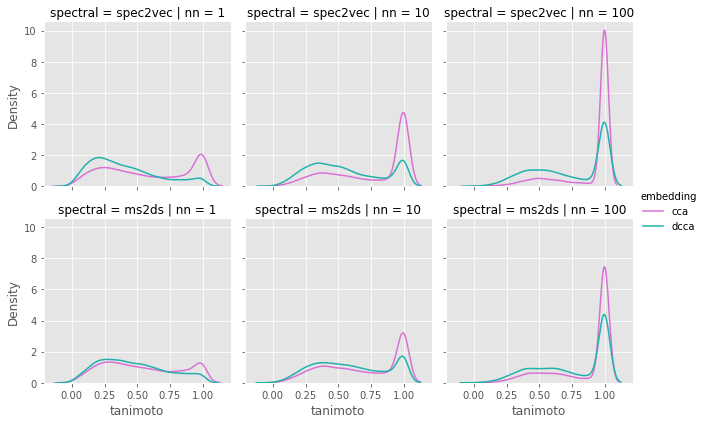

In [18]:
# Make distribution plots
def make_distribution_plot_spectral(tanimoto_df, title, p):
    tanimoto_df_m = tanimoto_df.melt(id_vars=['embedding', 'spectral'], var_name='nn', value_name='tanimoto')
    g = sns.FacetGrid(tanimoto_df_m, row='spectral', col='nn', hue='embedding', height=3, aspect=1, palette=p)
    g.map(sns.kdeplot, 'tanimoto')
    g.add_legend()

make_distribution_plot_spectral(comb_tanimoto_df_self, "",  ["orchid", "lightseagreen"])